# PROJECT LUNG DISEASES

# REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

# Initiation Directory

In [2]:
# flow_from_directory
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

# Datagenerator

In [3]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16,
    shuffle= True
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 8
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

In [5]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = True
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(TimeDistributed(Flatten()))
model_resnet.add(Bidirectional(LSTM(50, activation="relu", return_sequences=True, recurrent_dropout=0.2, dropout=0.2)))
model_resnet.add(Bidirectional(LSTM(50, activation="relu", return_sequences=False, recurrent_dropout=0.2, dropout=0.2)))
model_resnet.add(Flatten())
model_resnet.add(BatchNormalization())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_resnet.summary())

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 14336)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 100)            5754800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               60400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________

In [7]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [6]:
model_resnet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30, 
    verbose=1, 
    callbacks=[reduce_lr, 
               early_stopping]
)

Epoch 1/30
380/380 [==============================] - 142s 308ms/step - loss: 0.6496 - acc: 0.7671 - val_loss: 2.8735 - val_acc: 0.1426
Epoch 2/30
380/380 [==============================] - 112s 295ms/step - loss: 0.3002 - acc: 0.9054 - val_loss: 1.5284 - val_acc: 0.3849
Epoch 3/30
380/380 [==============================] - 113s 297ms/step - loss: 0.1839 - acc: 0.9452 - val_loss: 0.4770 - val_acc: 0.8381
Epoch 4/30
380/380 [==============================] - 114s 300ms/step - loss: 0.1370 - acc: 0.9617 - val_loss: 0.2946 - val_acc: 0.9053
Epoch 5/30
380/380 [==============================] - 111s 293ms/step - loss: 0.0956 - acc: 0.9737 - val_loss: 0.2159 - val_acc: 0.9399
Epoch 6/30
380/380 [==============================] - 111s 292ms/step - loss: 0.0734 - acc: 0.9783 - val_loss: 0.3595 - val_acc: 0.8778
Epoch 7/30
380/380 [==============================] - 111s 292ms/step - loss: 0.0872 - acc: 0.9743 - val_loss: 0.3323 - val_acc: 0.8931

Epoch 00007: ReduceLROnPlateau reducing learnin

In [7]:
model_resnet.save("resnet_model.h5")
with open('history_resnet.txt', mode='w') as file:
    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
    file.close()

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


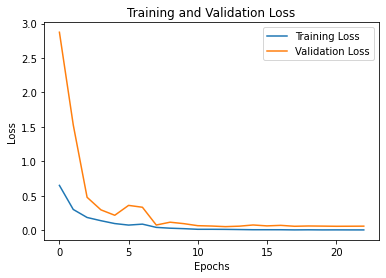

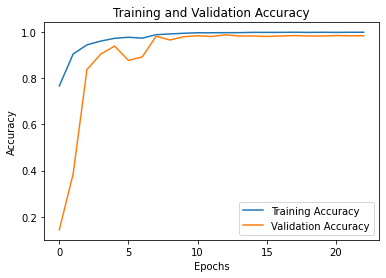

In [8]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
results_val = model_resnet.evaluate(val_generator)
results_train = model_resnet.evaluate(train_generator)
print("Val Loss:", results_val[0])
print("Val Accuracy:", results_val[1])
print("Train Loss:", results_train[0])
print("Train Accuracy:", results_train[1])

123/123 [==============================] - 5s 43ms/step - loss: 0.0510 - acc: 0.9888
Loss: 0.05098441243171692
Accuracy: 0.9887983798980713


In [13]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names= list(train_generator.class_indices.keys()),
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)

380/380 [==============================] - 28s 75ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20574   0.20574   0.20574      1220
            covid19    0.20113   0.20113   0.20113      1243
             normal    0.21134   0.21134   0.21134      1235
       tuberculosis    0.18718   0.18718   0.18718      1170
    viral_pneumonia    0.20050   0.20050   0.20050      1212

           accuracy                        0.20132      6080
          macro avg    0.20117   0.20117   0.20117      6080
       weighted avg    0.20132   0.20132   0.20132      6080



380/380 [==============================] - 27s 65ms/step


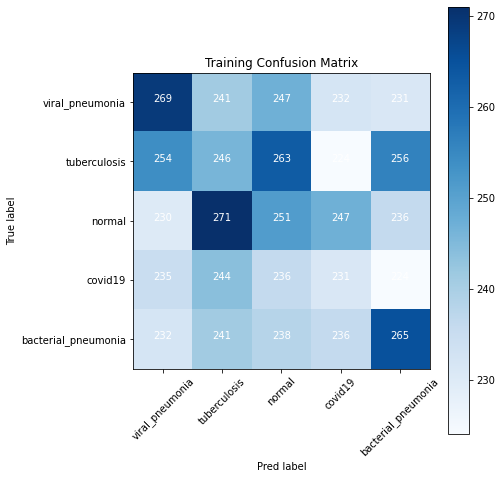

In [12]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
train_true_labels = train_generator.classes
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [5]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = True
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(TimeDistributed(Flatten()))
model_VGG19.add(Bidirectional(LSTM(50, activation="relu", return_sequences=True, recurrent_dropout=0.2, dropout=0.2)))
model_VGG19.add(Bidirectional(LSTM(50, activation="relu", return_sequences=False, recurrent_dropout=0.2, dropout=0.2)))
model_VGG19.add(Flatten())
model_VGG19.add(BatchNormalization())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 3584)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 100)            1454000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               60400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________

In [9]:
# Compile model
model_VGG19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30, 
    verbose=1, 
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/30
380/380 [==============================] - 164s 368ms/step - loss: 0.8857 - acc: 0.6543 - val_loss: 0.5759 - val_acc: 0.8218
Epoch 2/30
380/380 [==============================] - 134s 351ms/step - loss: 0.4869 - acc: 0.8242 - val_loss: 0.2442 - val_acc: 0.9246
Epoch 3/30
380/380 [==============================] - 134s 352ms/step - loss: 0.3824 - acc: 0.8655 - val_loss: 0.3488 - val_acc: 0.8635
Epoch 4/30
380/380 [==============================] - 134s 352ms/step - loss: 0.3006 - acc: 0.8933 - val_loss: 0.2164 - val_acc: 0.9277
Epoch 5/30
380/380 [==============================] - 134s 352ms/step - loss: 0.2315 - acc: 0.9199 - val_loss: 0.5159 - val_acc: 0.8411
Epoch 6/30
380/380 [==============================] - 134s 352ms/step - loss: 0.2036 - acc: 0.9255 - val_loss: 0.4668 - val_acc: 0.8422

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/30
380/380 [==============================] - 134s 351ms/step - loss: 0.1230 - acc: 0.9553 - va

In [ ]:
model_VGG19.save("VGG19_model_skenario1.h5")
with open('history_VGG19.txt', mode='w') as file:
    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
    file.close()

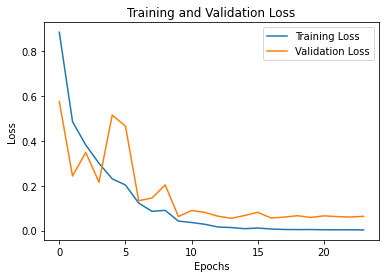

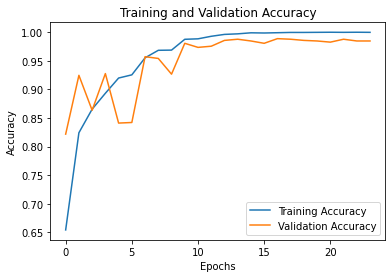

In [11]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
results_val = model_VGG19.evaluate(val_generator)
results_train = model_VGG19.evaluate(train_generator)
print("Val Loss:", results_val[0])
print("Val Accuracy:", results_val[1])
print("Train Loss:", results_train[0])
print("Train Accuracy:", results_train[1])

380/380 [==============================] - 33s 86ms/step - loss: 0.0029 - acc: 0.9998
Val Loss: 0.0549994595348835
Val Accuracy: 0.9877800345420837
Train Loss: 0.002921628300100565
Train Accuracy: 0.9998355507850647


In [ ]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)

y_true = train_generator.classes
confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred), range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()



In [ ]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


In [15]:
InceptionV3_model = InceptionV3(weights='imagenet', 
                                include_top=False, input_shape=(224, 224, 3))
# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = True
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(TimeDistributed(Flatten()))
model_InceptionV3.add(Bidirectional(LSTM(50, activation="relu", return_sequences=True, recurrent_dropout=0.2, dropout=0.2)))
model_InceptionV3.add(Bidirectional(LSTM(50, activation="relu", return_sequences=False, recurrent_dropout=0.2, dropout=0.2)))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(BatchNormalization())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_InceptionV3.summary())

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 10240)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5, 100)            4116400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               60400     
_________________________________________________________________
flatten_3 (Flatten)          (None, 100)               0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 100)               400       
_______________________________________________________

In [17]:
# Compile model
model_InceptionV3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30, 
    verbose=1, 
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/30
380/380 [==============================] - 108s 238ms/step - loss: 1.5421 - acc: 0.3773 - val_loss: 1.1497 - val_acc: 0.5305
Epoch 2/30
380/380 [==============================] - 86s 227ms/step - loss: 1.2101 - acc: 0.5082 - val_loss: 0.9778 - val_acc: 0.5937
Epoch 3/30
380/380 [==============================] - 86s 226ms/step - loss: 1.0491 - acc: 0.5757 - val_loss: 0.8903 - val_acc: 0.6426
Epoch 4/30
380/380 [==============================] - 86s 227ms/step - loss: 0.9847 - acc: 0.5952 - val_loss: 0.8356 - val_acc: 0.6568
Epoch 5/30
380/380 [==============================] - 86s 226ms/step - loss: 0.9164 - acc: 0.6288 - val_loss: 0.7700 - val_acc: 0.6802
Epoch 6/30
380/380 [==============================] - 86s 227ms/step - loss: 0.8621 - acc: 0.6632 - val_loss: 0.7235 - val_acc: 0.6976
Epoch 7/30
380/380 [==============================] - 86s 226ms/step - loss: 0.8047 - acc: 0.6801 - val_loss: 0.6975 - val_acc: 0.7210
Epoch 8/30
380/380 [==============================] - 

In [ ]:
model_InceptionV3.save("InceptionV3_model.h5")
with open('history_InceptionV3.txt', mode='w') as file:
    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
    file.close()

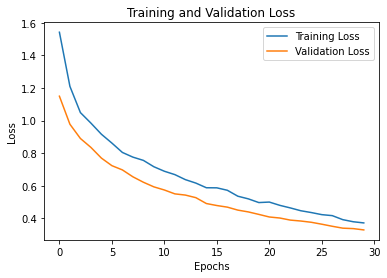

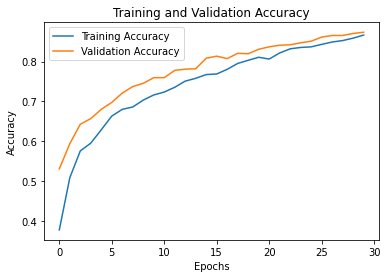

In [18]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
results_val = model_InceptionV3.evaluate(val_generator)
results_train = model_InceptionV3.evaluate(train_generator)
print("Val Loss:", results_val[0])
print("Val Accuracy:", results_val[1])
print("Train Loss:", results_train[0])
print("Train Accuracy:", results_train[1])

380/380 [==============================] - 24s 63ms/step - loss: 0.2084 - acc: 0.9383
Val Loss: 0.3293745517730713
Val Accuracy: 0.8737270832061768
Train Loss: 0.2083633989095688
Train Accuracy: 0.9383223652839661


In [ ]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



In [ ]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()